# Using scikit-learn with Spark on Databricks

This notebook demonstrates how to take advantage of Spark and Databricks to use [scikit-learn](http://scikit-learn.org/), the popular Python library for doing Machine Learning on a single compute node.

Even though the algorithms in scikit-learn are not distributed, we can still take advantage of distributed computation for certain ML tasks.  This can help with the transition from single-node workflows to fully distributed workflows: One can start by porting an existing workflow to Spark, begin to distribute certain tasks, and eventually move to fully distributed training via MLlib algorithms.

**Contents**
1. Running scikit-learn on the driver
2. Distributing scikit-learn jobs
3. Converting between scikit-learn and MLlib models

## 1. Running scikit-learn on the driver

The simplest way to use scikit-learn with Spark and Databricks is to run scikit-learn jobs as usual.  However, this will run scikit-learn jobs on the driver, so **be careful** not to run large jobs, especially if other users are working on the same cluster as you.  Nevertheless, a reasonable way to port existing scikit-learn workflows to Spark and start benefiting from distributed computing is to: (a) copy the workflow into Databricks and (b) start parallelizing the workflow piece-by-piece.  We discuss parallelization in the next section.

In this section, we will do the following:
* Load data into a Pandas dataframe
* Explore the data
* Transform features
* Hold out a random test dataset
* Learn an initial model
* Evaluate the initial model

### Load data into a Pandas dataframe

We will use the R "diamonds" dataset from the "ggplot2" package.  This is a dataset hosted on Databricks.

Our task will be to predict the price of a diamond from its properties.

In [0]:
displayHTML(sc.wholeTextFiles("/databricks-datasets/Rdatasets/data-001/doc/ggplot2/diamonds.html").take(1)[0][1])

diamonds,R Documentation


In [0]:
# Load data into a Pandas dataframe
import pandas
pandasData = pandas.read_csv("/dbfs/databricks-datasets/Rdatasets/data-001/csv/ggplot2/diamonds.csv").iloc[:,1:] # remove line number

### Explore the data

We quickly demonstrate how to start exploring the data.  For a longer tutorial, see the [Visualizations](https://docs.databricks.com/user-guide/visualizations/index.html).

In [0]:
# We can view the Pandas dataframe using Pandas' native display
pandasData

Out[ 3 ]: 
 carat cut color clarity depth table price x y z
0 0.23 Ideal E SI2 61.5 55.0 326 3.95 3.98 2.43
1 0.21 Premium E SI1 59.8 61.0 326 3.89 3.84 2.31
2 0.23 Good E VS1 56.9 65.0 327 4.05 4.07 2.31
3 0.29 Premium I VS2 62.4 58.0 334 4.20 4.23 2.63
4 0.31 Good J SI2 63.3 58.0 335 4.34 4.35 2.75
5 0.24 Very Good J VVS2 62.8 57.0 336 3.94 3.96 2.48
6 0.24 Very Good I VVS1 62.3 57.0 336 3.95 3.98 2.47
7 0.26 Very Good H SI1 61.9 55.0 337 4.07 4.11 2.53
8 0.22 Fair E VS2 65.1 61.0 337 3.87 3.78 2.49
9 0.23 Very Good H VS1 59.4 61.0 338 4.00 4.05 2.39
10 0.30 Good J SI1 64.0 55.0 339 4.25 4.28 2.73
11 0.23 Ideal J VS1 62.8 56.0 340 3.93 3.90 2.46
12 0.22 Premium F SI1 60.4 61.0 342 3.88 3.84 2.33
13 0.31 Ideal J SI2 62.2 54.0 344 4.35 4.37 2.71
14 0.20 Premium E SI2 60.2 62.0 345 3.79 3.75 2.27
15 0.32 Premium E I1 60.9 58.0 345 4.38 4.42 2.68
16 0.30 Ideal I SI2 62.0 54.0 348 4.31 4.34 2.68
17 0.30 Good J SI1 63.4 54.0 351 4.23 4.29 2.70
18 0.30 Good J SI1 63.8 56.0 351 4.23 4.26 2.71
19 0.30 Very Good J SI1 62.7 59.0 351 4.21 4.27 2.66
20 0.30 Good I SI2 63.3 56.0 351 4.26 4.30 2.71
21 0.23 Very Good E VS2 63.8 55.0 352 3.85 3.92 2.48
22 0.23 Very Good H VS1 61.0 57.0 353 3.94 3.96 2.41
23 0.31 Very Good J SI1 59.4 62.0 353 4.39 4.43 2.62
24 0.31 Very Good J SI1 58.1 62.0 353 4.44 4.47 2.59
25 0.23 Very Good G VVS2 60.4 58.0 354 3.97 4.01 2.41
26 0.24 Premium I VS1 62.5 57.0 355 3.97 3.94 2.47
27 0.30 Very Good J VS2 62.2 57.0 357 4.28 4.30 2.67
28 0.23 Very Good D VS2 60.5 61.0 357 3.96 3.97 2.40
29 0.23 Very Good F VS1 60.9 57.0 357 3.96 3.99 2.42
... ... ... ... ... ... ... ... ... ... ...
53910 0.70 Premium E SI1 60.5 58.0 2753 5.74 5.77 3.48
53911 0.57 Premium E IF 59.8 60.0 2753 5.43 5.38 3.23
53912 0.61 Premium F VVS1 61.8 59.0 2753 5.48 5.40 3.36
53913 0.80 Good G VS2 64.2 58.0 2753 5.84 5.81 3.74
53914 0.84 Good I VS1 63.7 59.0 2753 5.94 5.90 3.77
53915 0.77 Ideal E SI2 62.1 56.0 2753 5.84 5.86 3.63
53916 0.74 Good D SI1 63.1 59.0 2753 5.71 5.74 3.61
53917 0.90 Very Good J SI1 63.2 60.0 2753 6.12 6.09 3.86
53918 0.76 Premium I VS1 59.3 62.0 2753 5.93 5.85 3.49
53919 0.76 Ideal I VVS1 62.2 55.0 2753 5.89 5.87 3.66
53920 0.70 Very Good E VS2 62.4 60.0 2755 5.57 5.61 3.49
53921 0.70 Very Good E VS2 62.8 60.0 2755 5.59 5.65 3.53
53922 0.70 Very Good D VS1 63.1 59.0 2755 5.67 5.58 3.55
53923 0.73 Ideal I VS2 61.3 56.0 2756 5.80 5.84 3.57
53924 0.73 Ideal I VS2 61.6 55.0 2756 5.82 5.84 3.59
53925 0.79 Ideal I SI1 61.6 56.0 2756 5.95 5.97 3.67
53926 0.71 Ideal E SI1 61.9 56.0 2756 5.71 5.73 3.54
53927 0.79 Good F SI1 58.1 59.0 2756 6.06 6.13 3.54
53928 0.79 Premium E SI2 61.4 58.0 2756 6.03 5.96 3.68
53929 0.71 Ideal G VS1 61.4 56.0 2756 5.76 5.73 3.53
53930 0.71 Premium E SI1 60.5 55.0 2756 5.79 5.74 3.49
53931 0.71 Premium F SI1 59.8 62.0 2756 5.74 5.73 3.43
53932 0.70 Very Good E VS2 60.5 59.0 2757 5.71 5.76 3.47
53933 0.70 Very Good E VS2 61.2 59.0 2757 5.69 5.72 3.49
53934 0.72 Premium D SI1 62.7 59.0 2757 5.69 5.73 3.58
53935 0.72 Ideal D SI1 60.8 57.0 2757 5.75 5.76 3.50
53936 0.72 Good D SI1 63.1 55.0 2757 5.69 5.75 3.61
53937 0.70 Very Good D SI1 62.8 60.0 2757 5.66 5.68 3.56
53938 0.86 Premium H SI2 61.0 58.0 2757 6.15 6.12 3.74
53939 0.75 Ideal D SI2 62.2 55.0 2757 5.83 5.87 3.64

[53940 rows x 10 columns]

We can make plots using Python tools like matplotlib.

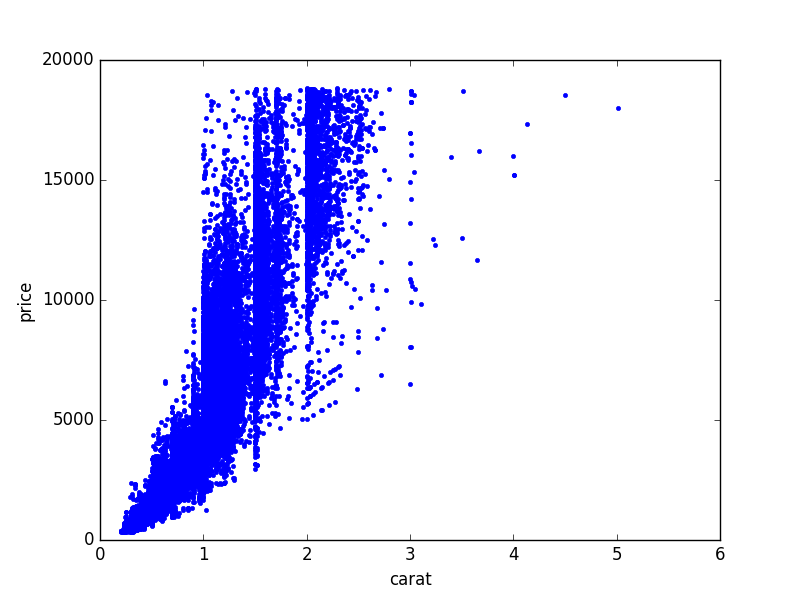

In [0]:
import matplotlib.pyplot as plt
plt.clf()
plt.plot(pandasData['carat'], pandasData['price'], '.')
plt.xlabel('carat')
plt.ylabel('price')
display()

We can also convert the Pandas dataframe into a Spark DataFrame and use Databricks display methods.

In [0]:
# Create this plot by calling display on the Spark DataFrame, clicking the plot icon, selecting Plot Options, and creating a Histogram of 'carat' values.
sparkDataframe = spark.createDataFrame(pandasData)
display(sparkDataframe)

carat,cut,color,clarity,depth,table,price,x,y,z
0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
0.29,Premium,I,VS2,62.4,58.0,334,4.2,4.23,2.63
0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
0.24,Very Good,J,VVS2,62.8,57.0,336,3.94,3.96,2.48
0.24,Very Good,I,VVS1,62.3,57.0,336,3.95,3.98,2.47
0.26,Very Good,H,SI1,61.9,55.0,337,4.07,4.11,2.53
0.22,Fair,E,VS2,65.1,61.0,337,3.87,3.78,2.49
0.23,Very Good,H,VS1,59.4,61.0,338,4.0,4.05,2.39


### Transform features

Some of our features are text, and we want them to be numerical so we can train a linear model.  We use the Pandas and scikit-learn APIs for these transformations.

First, we convert the features to numerical values, in the correct order based on the feature meanings.  Higher indices are "better."  This ordering will help us interpret model weights later on.

In [0]:
pandasData['cut'] = pandasData['cut'].replace({'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4})
pandasData['color'] = pandasData['color'].replace({'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6})
pandasData['clarity'] = pandasData['clarity'].replace({'I1':0, 'SI1':1, 'SI2':2, 'VS1':3, 'VS2':4, 'VVS1':5, 'VVS2':6, 'IF':7})
pandasData

Out[ 6 ]: 
 carat cut color clarity depth table price x y z
0 0.23 4 5 2 61.5 55.0 326 3.95 3.98 2.43
1 0.21 3 5 1 59.8 61.0 326 3.89 3.84 2.31
2 0.23 1 5 3 56.9 65.0 327 4.05 4.07 2.31
3 0.29 3 1 4 62.4 58.0 334 4.20 4.23 2.63
4 0.31 1 0 2 63.3 58.0 335 4.34 4.35 2.75
5 0.24 2 0 6 62.8 57.0 336 3.94 3.96 2.48
6 0.24 2 1 5 62.3 57.0 336 3.95 3.98 2.47
7 0.26 2 2 1 61.9 55.0 337 4.07 4.11 2.53
8 0.22 0 5 4 65.1 61.0 337 3.87 3.78 2.49
9 0.23 2 2 3 59.4 61.0 338 4.00 4.05 2.39
10 0.30 1 0 1 64.0 55.0 339 4.25 4.28 2.73
11 0.23 4 0 3 62.8 56.0 340 3.93 3.90 2.46
12 0.22 3 4 1 60.4 61.0 342 3.88 3.84 2.33
13 0.31 4 0 2 62.2 54.0 344 4.35 4.37 2.71
14 0.20 3 5 2 60.2 62.0 345 3.79 3.75 2.27
15 0.32 3 5 0 60.9 58.0 345 4.38 4.42 2.68
16 0.30 4 1 2 62.0 54.0 348 4.31 4.34 2.68
17 0.30 1 0 1 63.4 54.0 351 4.23 4.29 2.70
18 0.30 1 0 1 63.8 56.0 351 4.23 4.26 2.71
19 0.30 2 0 1 62.7 59.0 351 4.21 4.27 2.66
20 0.30 1 1 2 63.3 56.0 351 4.26 4.30 2.71
21 0.23 2 5 4 63.8 55.0 352 3.85 3.92 2.48
22 0.23 2 2 3 61.0 57.0 353 3.94 3.96 2.41
23 0.31 2 0 1 59.4 62.0 353 4.39 4.43 2.62
24 0.31 2 0 1 58.1 62.0 353 4.44 4.47 2.59
25 0.23 2 3 6 60.4 58.0 354 3.97 4.01 2.41
26 0.24 3 1 3 62.5 57.0 355 3.97 3.94 2.47
27 0.30 2 0 4 62.2 57.0 357 4.28 4.30 2.67
28 0.23 2 6 4 60.5 61.0 357 3.96 3.97 2.40
29 0.23 2 4 3 60.9 57.0 357 3.96 3.99 2.42
... ... ... ... ... ... ... ... ... ... ...
53910 0.70 3 5 1 60.5 58.0 2753 5.74 5.77 3.48
53911 0.57 3 5 7 59.8 60.0 2753 5.43 5.38 3.23
53912 0.61 3 4 5 61.8 59.0 2753 5.48 5.40 3.36
53913 0.80 1 3 4 64.2 58.0 2753 5.84 5.81 3.74
53914 0.84 1 1 3 63.7 59.0 2753 5.94 5.90 3.77
53915 0.77 4 5 2 62.1 56.0 2753 5.84 5.86 3.63
53916 0.74 1 6 1 63.1 59.0 2753 5.71 5.74 3.61
53917 0.90 2 0 1 63.2 60.0 2753 6.12 6.09 3.86
53918 0.76 3 1 3 59.3 62.0 2753 5.93 5.85 3.49
53919 0.76 4 1 5 62.2 55.0 2753 5.89 5.87 3.66
53920 0.70 2 5 4 62.4 60.0 2755 5.57 5.61 3.49
53921 0.70 2 5 4 62.8 60.0 2755 5.59 5.65 3.53
53922 0.70 2 6 3 63.1 59.0 2755 5.67 5.58 3.55
53923 0.73 4 1 4 61.3 56.0 2756 5.80 5.84 3.57
53924 0.73 4 1 4 61.6 55.0 2756 5.82 5.84 3.59
53925 0.79 4 1 1 61.6 56.0 2756 5.95 5.97 3.67
53926 0.71 4 5 1 61.9 56.0 2756 5.71 5.73 3.54
53927 0.79 1 4 1 58.1 59.0 2756 6.06 6.13 3.54
53928 0.79 3 5 2 61.4 58.0 2756 6.03 5.96 3.68
53929 0.71 4 3 3 61.4 56.0 2756 5.76 5.73 3.53
53930 0.71 3 5 1 60.5 55.0 2756 5.79 5.74 3.49
53931 0.71 3 4 1 59.8 62.0 2756 5.74 5.73 3.43
53932 0.70 2 5 4 60.5 59.0 2757 5.71 5.76 3.47
53933 0.70 2 5 4 61.2 59.0 2757 5.69 5.72 3.49
53934 0.72 3 6 1 62.7 59.0 2757 5.69 5.73 3.58
53935 0.72 4 6 1 60.8 57.0 2757 5.75 5.76 3.50
53936 0.72 1 6 1 63.1 55.0 2757 5.69 5.75 3.61
53937 0.70 2 6 1 62.8 60.0 2757 5.66 5.68 3.56
53938 0.86 3 2 2 61.0 58.0 2757 6.15 6.12 3.74
53939 0.75 4 6 2 62.2 55.0 2757 5.83 5.87 3.64

[53940 rows x 10 columns]

Now, we normalize each feature (column) to have unit variance.  (This normalization or standardization often improves performance. See [Wikipedia](http://en.wikipedia.org/wiki/Feature_scaling#Standardization) for more info.)

In [0]:
# Split data into a labels dataframe and a features dataframe
labels = pandasData['price'].values
featureNames = ['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']
features = pandasData[featureNames].values

In [0]:
# Normalize features (columns) to have unit variance
from sklearn.preprocessing import normalize
features = normalize(features, axis=0)
features

Out[ 8 ]: 
array([[ 0.00106702, 0.00553547, 0.005655 , ..., 0.0029123 ,
 0.00293078, 0.00289958],
 [ 0.00097424, 0.0041516 , 0.005655 , ..., 0.00286806,
 0.00282769, 0.00275639],
 [ 0.00106702, 0.00138387, 0.005655 , ..., 0.00298603,
 0.00299705, 0.00275639],
 ..., 
 [ 0.00324745, 0.00276773, 0.006786 , ..., 0.00417307,
 0.00418262, 0.00424794],
 [ 0.00398973, 0.0041516 , 0.002262 , ..., 0.00453434,
 0.00450662, 0.00446272],
 [ 0.00347941, 0.00553547, 0.006786 , ..., 0.0042984 ,
 0.00432253, 0.0043434 ]])

### Hold out a random test set

We hold out a random sample of the data for testing.  Note that this randomness can cause this notebook to produce different results each time it is run.

In [0]:
# Hold out 30% of the data for testing.  We will use the rest for training.
from sklearn.cross_validation import train_test_split
trainingLabels, testLabels, trainingFeatures, testFeatures = train_test_split(labels, features, test_size=0.3)
ntrain, ntest = len(trainingLabels), len(testLabels)
print('Split data randomly into 2 sets: %d training and %d test instances.' % (ntrain, ntest))

/databricks/python/local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
 "This module will be removed in 0.20.", DeprecationWarning)
Split data randomly into 2 sets: 37758 training and 16182 test instances.

### Learn an initial model

Here, we train a single model using fixed hyperparameters on the driver.  Later, we will do model tuning by training models in a distributed fashion.

In [0]:
# Train a model with fixed hyperparameters, and print out the intercept and coefficients.
from sklearn import linear_model
origAlpha = 0.5 # "alpha" is the regularization hyperparameter
origClf = linear_model.Ridge(alpha=origAlpha)
origClf.fit(features, labels)
print('Trained model with fixed alpha = %g' % origAlpha)
print('  Model intercept: %g' % origClf.intercept_)
print('  Model coefficients:')
for i in range(len(featureNames)):
  print ('    %g\t%s' % (origClf.coef_[i], featureNames[i]))

Trained model with fixed alpha = 0.5
 Model intercept: -57.6952
 Model coefficients:
 503932	carat
 -668.814	cut
 -36580.6	color
 4104.09	clarity
 -887.179	depth
 4074.86	table
 178054	x
 176814	y
 175385	z

One can draw conclusions about the model coefficients and the affect of features.  However, be wary of several issues:
* Feature meaning: Especially if you index or transform features, be careful about how those transformations can change the meaning.  E.g., reversing an index order or negating a numerical feature can "flip" the meaning.
* Model assumptions: The model may not fit the data, in which case interpreting coefficients may be difficult.  E.g., if the data do not correspond to a linear model, the model may learn non-intuitive weights for some features (in its attempt to fit the data as well as possible).

### Evaluate the initial model

We will evaluate this and other models using [scikit-learn's score function](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge.score), which computes a value indicating the quality of the model's predictions on data.  A value closer to `1` is better.

In [0]:
# Score the initial model.  It does not do that well.
origScore = origClf.score(trainingFeatures, trainingLabels)
origScore

Out[ 11 ]: 0.56071451099811531

## 2. Distributing scikit-learn jobs

Now that we have a basic scikit-learn workflow in Databricks, we can start distributing tasks.  There are several types of tasks one might distribute, such as ETL, parameter tuning, and evaluation.  We demonstrate using Spark to distribute *parameter tuning* below.

### Parameter tuning using Spark

[Parameter tuning](http://en.wikipedia.org/wiki/Hyperparameter_optimization) is the task of tuning (hyper)parameters of a learning or prediction system in order to improve the results.  It is commonly done by training multiple models (each using different parameters) on one set of data and then testing those models on another held-out set of data (and maybe repeating).  By testing on a held-out set not seen during training, we can tune the parameters in a data-driven way while limiting the risk of [overfitting](http://en.wikipedia.org/wiki/Overfitting).

In this section, we will use [k-fold cross validation](http://en.wikipedia.org/wiki/Cross-validation_&#40;statistics&#41;), which works as follows:
* Randomly split the data into k equal-sized subsets ("folds").
* For ```i = 1, 2, ..., k```,
  * Hold out fold ```i``` as a validation set.
  * Create a training set by combining all folds except for ```i```.
  * For each set of parameters,
    * Train a model with that set of parameters.
    * Test the model on the validation set to compute a validation error.
* For each set of parameters,
  * Compute the average validation error (averaging over the ```k``` models for this set of parameters).
* Choose the best set of parameters, based on the average validation error.
* Re-train on the entire dataset, using this best set of parameters.

Note that for each (fold, parameter set) pair, the task of training a model can be done independently of other folds and parameter sets.  We will parallelize these tasks: scikit-learn will be used on each worker to do the training.  This parallelization is especially helpful since training is the most computationally costly part of this workflow.  If you use `k` folds of cross validation to test `P` different parameter settings, then distributing the task to train 1 model per worker can make it run close to `k*P` times faster!

We will also hold out some additional data for testing.  We will use it to demonstrate the worth of careful parameter tuning by comparing:
* Our initial model (with poorly chosen parameters)
* The final model (with carefully tuned parameters)

#### Split data and define tasks to distribute

Each distributed task will be a (fold, parameter set) pair.  It will correspond to 1 model we train.

In [0]:
# We use scikit-learn's cross_validation module, which helps split our data randomly into k equal-size parts ("folds").
from sklearn import cross_validation
numFolds = 3 # You may want to use more (10 or so) in practice
kf = cross_validation.KFold(ntrain, n_folds=numFolds)

In [0]:
# "alphas" is a list of hyperparameter values to test
alphas = [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
# Create a list of tasks to distribute
tasks = []
for alpha in alphas:
  for fold in range(numFolds):
    tasks = tasks + [(alpha, fold)]

In [0]:
# Create an RDD of tasks.  We set the number of partitions equal to the number of tasks to ensure maximum parallelism.
tasksRDD = sc.parallelize(tasks, numSlices = len(tasks))

#### Broadcast dataset

If we use a variable in a function (a "closure") run on each worker, Spark will automatically send the dataset to the workers.  This is fine for variables with small values, but for our dataset, we can send it to workers more efficiently by *broadcasting* it.  We now create a *broadcast variable* for our data, which we will use later when running tasks on workers.  For more info on broadcast variables, see the [Spark programming guide](https://spark.apache.org/docs/latest/programming-guide.html#broadcast-variables).

In [0]:
trainingFeaturesBroadcast = sc.broadcast(trainingFeatures)
trainingLabelsBroadcast = sc.broadcast(trainingLabels)

#### Run cross-validation in parallel

We define a function which will run on each worker.  This function takes 1 task (1 hyperparameter alpha value + 1 fold index) and trains the corresponding model.  We then use `RDD.map` to run these tasks in parallel.

In [0]:
def trainOneModel(alpha, fold):
  """
  Given 1 task (1 hyperparameter alpha value + 1 fold index), train the corresponding model.
  Return: model, score on the fold's test data, task info.
  """
  # Extract indices for this fold
  trainIndex, valIndex = [], []
  fold_ = 0 # index into folds 'kf'
  for trainIndex_, valIndex_ in kf:
    if fold_ == fold:
      trainIndex, valIndex = trainIndex_, valIndex_
      break
    fold_ += 1
  # Get training data from the broadcast variables
  localTrainingFeatures = trainingFeaturesBroadcast.value
  localTrainingLabels = trainingLabelsBroadcast.value
  X_train, X_val = localTrainingFeatures[trainIndex], localTrainingFeatures[valIndex]
  Y_train, Y_val = localTrainingLabels[trainIndex], localTrainingLabels[valIndex]
  # Train the model, and score it
  clf = linear_model.Ridge(alpha=alpha)
  clf.fit(X_train, Y_train)
  score = clf.score(X_val, Y_val)
  return clf, score, alpha, fold

In [0]:
# LEARN!  We now map our tasks RDD and apply the training function to each task.
# After we call an action ("count") on the results, the actual training is executed.
trainedModelAndScores = tasksRDD.map(lambda alpha_fold: trainOneModel(alpha_fold[0], alpha_fold[1]))
trainedModelAndScores.cache()
trainedModelAndScores.count()

Out[ 17 ]: 27

In [0]:
# Since we are done with our broadcast variables, we can clean them up.
# (This will happen automatically, but we can make it happen earlier by explicitly unpersisting the broadcast variables.
trainingFeaturesBroadcast.unpersist()
trainingLabelsBroadcast.unpersist()

#### Collect results to get the best hyperparameter alpha

In [0]:
# Collect the results.
allScores = trainedModelAndScores.map(lambda x: (x[1], x[2], x[3])).collect()
# Average scores over folds
avgScores = dict(map(lambda alpha: (alpha, 0.0), alphas))
for score, alpha, fold in allScores:
  avgScores[alpha] += score
for alpha in alphas:
  avgScores[alpha] /= numFolds
avgScores

Out[ 19 ]: 
{0.0: 0.89550811893405935,
 0.0001: 0.89508063424062778,
 0.001: 0.89295174773527874,
 0.01: 0.87959534981082876,
 0.1: 0.73256647358457572,
 1.0: 0.2301860735636645,
 10.0: 0.028483844976623301,
 100.0: 0.0025958845202008383,
 1000.0: -6.5310553291101733e-05}

We now have a list of alpha values paired with the corresponding average scores (averaged over the k folds).  Let's identify the best score to discover the best value for alpha.

In [0]:
# Find best score
bestAlpha = -1
bestScore = -1
for alpha in alphas:
  if avgScores[alpha] > bestScore:
    bestAlpha = alpha
    bestScore = avgScores[alpha]
print('Found best alpha: %g, which gives score: %g' % (bestAlpha, bestScore))

Found best alpha: 0, which gives score: 0.895508

We can also use plotting to examine how the hyperparameter affects performance.

In [0]:
# Use Databricks' display() function to plot the scores vs. alpha.  We use a namedtuple to tell Databricks names for the columns (alpha and the score).
import numpy
from collections import namedtuple
Score = namedtuple('Score', 'log_alpha score')
df = spark.createDataFrame(map(lambda alpha: Score(float(numpy.log(alpha + 0.00000001)), float(avgScores[alpha])), avgScores)).toDF('log_alpha score','Score')
display(df)

log_alpha score,Score
-18.420680743952367,0.8955081189340593
9.999999889225291E-9,0.2301860735636645
4.605170186088091,0.0025958845202008383
-2.3025849929940505,0.7325664735845757
6.907755278992137,-6.531055329110173E-5
2.302585093994046,0.0284838449766233
-6.907745279032137,0.8929517477352787
-9.21024037697585,0.8950806342406278
-4.605169185988592,0.8795953498108288


For this dataset, the best alpha is generally small but not the smallest value.  (Remember that the results of this notebook can vary because of randomness in splitting the data.)

This demonstrates how parameter tuning can help *a lot*; our score can vary from 0 (terrible) to 0.9 (quite good).

#### Train a final model using the best hyperparameter

We use our chosen value of alpha to train a model on the entire training dataset.  Since this is a single training task, we execute it on the driver.

In [0]:
# Use bestAlpha, and train a final model.
tunedClf = linear_model.Ridge(alpha=bestAlpha)
tunedClf.fit(trainingFeatures, trainingLabels)

Out[ 22 ]: 
Ridge(alpha=0.0, copy_X=True, fit_intercept=True, max_iter=None,
 normalize=False, random_state=None, solver='auto', tol=0.001)

Let's compare our original model vs. the final model with tuned hyperparameters.

In [0]:
origTrainingScore, origTestScore = origClf.score(trainingFeatures, trainingLabels), origClf.score(testFeatures, testLabels)
tunedTrainingScore, tunedTestScore = tunedClf.score(trainingFeatures, trainingLabels), tunedClf.score(testFeatures, testLabels)
print('Compare original model (without hyperparameter tuning) and final model (with tuning) on test data\n')
print('Model   \tAlpha\tTraining   \tTest')
print('Original\t%g\t%g\t%g' % (origAlpha, origTrainingScore, origTestScore))
print('Tuned   \t%g\t%g\t%g' % (bestAlpha, tunedTrainingScore, tunedTestScore))

Compare original model (without hyperparameter tuning) and final model (with tuning) on test data

Model Alpha	Training Test
Original	0.5	0.560715	0.554803
Tuned 0	0.895896	0.892096

The tuned model does better! (Note: Performance can vary because of randomness, but it should be better.)

In [0]:
print('Tuned model with best alpha = %g' % bestAlpha)
print('  Model intercept: %g' % tunedClf.intercept_)
print('  Model coefficients:')
for i in range(len(featureNames)):
  print('    %g\t%s' % (tunedClf.coef_[i], featureNames[i]))

Tuned model with best alpha = 0
 Model intercept: 6532.42
 Model coefficients:
 2.31551e+06	carat
 99948.6	cut
 251040	color
 295415	clarity
 -1.42792e+06	depth
 -451475	table
 -1.35787e+06	x
 37163	y
 6641.69	z